In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [3]:
names = ['ssp585',
         'ssp370-lowNTCF',
         "ssp370",
         'ssp126',
         'hist-aer',
         'hist-GHG',
         'historical',
         #'abrupt-4xCO2',
         #'1pctCO2'
        ]

In [4]:
outputs={}
inputs={}
for name in names:
    inputs[f"{name}"] = xr.open_dataset(f"./train_val/inputs_{name}.nc")
    
    outputs_temp = xr.open_dataset(f"./train_val/outputs_{name}.nc").mean(dim='member')
    outputs_temp = outputs_temp.assign({"pr": outputs_temp.pr * 86400, "pr90": outputs_temp.pr90 * 86400})
    outputs_temp = outputs_temp.rename({'lon':'longitude', 'lat': 'latitude'})
    outputs[f"{name}"] = outputs_temp

In [61]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

In [6]:
slider=10

In [7]:
def training_input(X_train):
    X_train_np = X_train.to_array().transpose('time', 'latitude', 'longitude', 'variable').data

    time_length = X_train_np.shape[0]
    X_train_mod = np.array([X_train_np[i:i+slider] for i in range(0, time_length - slider+1)])

    return X_train_mod

def training_output(Y_train, var):
    Y_train_np = Y_train[var].data

    time_length = Y_train_np.shape[0]
    Y_train_mod = np.array([Y_train_np[i+slider-1] for i in range(0, time_length-slider+1)])

    return Y_train_mod

In [8]:
X = [inputs['ssp370'], inputs['ssp126']]

In [9]:
Y = [outputs['ssp370'], outputs['ssp126']]              

In [10]:
mean={}
std={}
input_vars = ['CO2', 'SO2', 'CH4', 'BC']
for var in input_vars:

    array = np.array(X[0][var].data + X[1][var].data)
    mean[var] = array.mean()
    std[var] = array.std()

In [11]:
print("Means ", mean)
print("Standard Deviation ", std)

Means  {'CO2': 6405.910174326076, 'SO2': 5.717767908934675e-12, 'CH4': 0.7688742321323471, 'BC': 5.054034441801042e-13}
Standard Deviation  {'CO2': 1906.325135441283, 'SO2': 3.772588788161702e-11, 'CH4': 0.04038698254177525, 'BC': 2.7361256290235744e-12}


In [12]:
def normalize(data, mean, std):
    return (data-mean)/std

def unnormalize(data, mean, std):
    return data * std + mean

In [13]:
X_norm = []
for i, training in enumerate(X):
    for var in input_vars:
        dims = X[i][var].dims
        training = training.assign({var: (dims, normalize(training[var].data, mean[var], std[var]))})
    X_norm.append(training)

In [14]:
X_norm

[<xarray.Dataset> Size: 19MB
 Dimensions:    (time: 86, longitude: 144, latitude: 96)
 Coordinates:
   * longitude  (longitude) float64 1kB 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
   * latitude   (latitude) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
   * time       (time) int64 688B 2015 2016 2017 2018 ... 2097 2098 2099 2100
 Data variables:
     CO2        (time) float64 688B -2.555 -2.535 -2.516 ... 0.104 0.1458 0.1878
     SO2        (time, latitude, longitude) float64 10MB -0.1516 ... -0.146
     CH4        (time) float64 688B -9.784 -9.638 -9.492 ... -0.5787 -0.4771
     BC         (time, latitude, longitude) float64 10MB -0.1847 ... -0.1826,
 <xarray.Dataset> Size: 19MB
 Dimensions:    (time: 86, longitude: 144, latitude: 96)
 Coordinates:
   * longitude  (longitude) float64 1kB 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
   * latitude   (latitude) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
   * time       (time) int64 688B 2015 2016 2017 2018 ... 2097 2098 2099 21

In [20]:
predict='tas'

In [21]:
X_trained = np.concatenate([training_input(X_norm[i]) for i in range(len(X))], axis = 0)
Y_trained = np.concatenate([training_output(Y[i], predict) for i in range(len(Y))], axis=0)
print(X_trained.shape)
print(Y_trained.shape)

(154, 10, 96, 144, 4)
(154, 96, 144)


In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Input, Reshape, AveragePooling2D, MaxPooling2D, Conv2DTranspose, TimeDistributed, LSTM, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

import random 
seed = 6 
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [19]:
cnn_model = Sequential()
cnn_model.add(Input(shape=(slider, 96, 144, 4)))
cnn_model.add(TimeDistributed(Conv2D(20, (3, 3), padding='same', activation='relu'), input_shape=(slider, 96, 144, 4)))
cnn_model.add(TimeDistributed(AveragePooling2D(2)))
cnn_model.add(TimeDistributed(GlobalAveragePooling2D()))
cnn_model.add(LSTM(25, activation='relu'))
cnn_model.add(Dense(1*96*144))
cnn_model.add(Activation('linear'))
cnn_model.add(Reshape((1, 96, 144)))

/glade/u/home/czwang/.local/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-11-20 14:49:56.293811: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [23]:
cnn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mse']) 

In [20]:
hist = cnn_model.fit(X_trained,
                     Y_trained,
                     #workers=5,
                     batch_size=16,
                     epochs=30,
                     verbose=1)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 6.0657 - mse: 6.0657
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 3.1280 - mse: 3.1280
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 2.4630 - mse: 2.4630
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 2.1525 - mse: 2.1525
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.8860 - mse: 1.8860
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.7504 - mse: 1.7504
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.7476 - mse: 1.7476
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.7007 - mse: 1.7007
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.3869 - mse: 1.3869
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.3828 - mse: 1.3828
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.4029 - mse: 1.4029
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.3384 - mse: 1.3384
Epoch 13/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/ste

In [21]:
cnn_model.save('./models/cnn_2.keras')

In [28]:
cnn_model = tf.keras.models.load_model('./models/cnn_2.keras')

In [29]:
X_test = xr.open_dataset(f"./test/inputs_ssp245.nc")
Y_test = xr.open_dataset(f"./test/outputs_ssp245.nc")

In [30]:
X_test_norm = xr.Dataset()
for var in input_vars:
    dims = X_test[var].dims
    X_test_norm = X_test_norm.assign({var: (dims, normalize(X_test[var].data, mean[var], std[var]))} )

In [31]:
X_test_new  = training_input(X_test_norm)

In [32]:
m_pred = cnn_model.predict(X_test_new)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


In [33]:
m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])

In [34]:
m_pred = xr.DataArray(m_pred, dims=['time', 'lat', 'lon'], coords=[X_test.time.data[slider-1:], X_test.latitude.data, X_test.longitude.data])
m_pred = m_pred.transpose('lat', 'lon', 'time').sel(time=slice(2015, 2101)).to_dataset(name=predict)
if ((predict == "pr90") | (predict == "pr")):
    m_pred = m_pred.assign({predict: m_pred[var_to_predict] / 86400})
m_pred

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 77, lat: 96, lon: 144)
Coordinates:
  * time     (time) int64 616B 2024 2025 2026 2027 2028 ... 2097 2098 2099 2100
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    tas      (lat, lon, time) float32 4MB 2.231 2.225 2.22 ... 4.415 4.413 4.412

In [62]:
get_rmse(Y_test['tas'].mean('member')[9:], m_pred['tas'])

0.6349405982873716

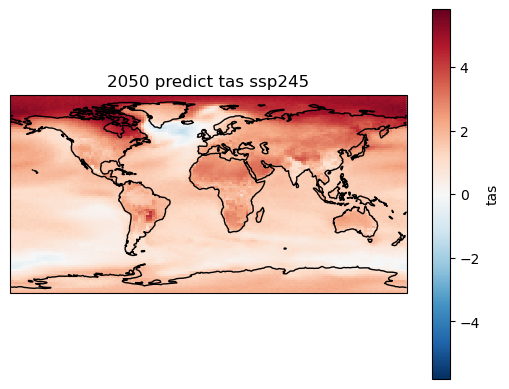

In [43]:
alpha = m_pred['tas'].sel(time=2050).plot(transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': ccrs.PlateCarree()})
plt.gca().set_title('2050 predict tas ssp245')
plt.gca().coastlines()

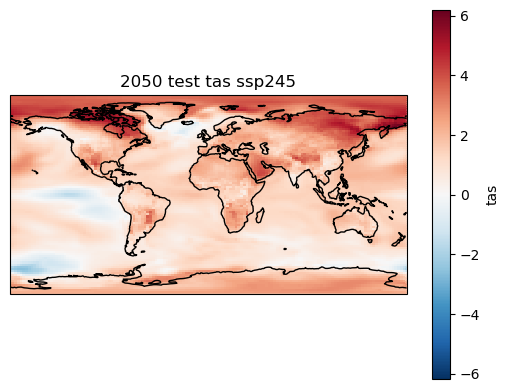

In [44]:
beta = Y_test['tas'].sel(time=2050, member=1).plot(transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': ccrs.PlateCarree()})
plt.gca().set_title('2050 test tas ssp245')
plt.gca().coastlines()

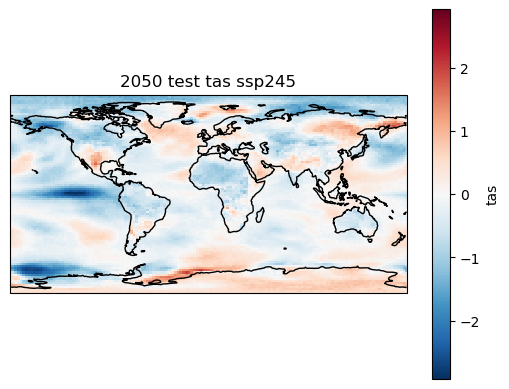

In [45]:
(Y_test['tas'].sel(member=1)-m_pred['tas']).sel(time=2050).plot(transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': ccrs.PlateCarree()})
plt.gca().set_title('2050 test tas ssp245')
plt.gca().coastlines()

In [62]:
X = [inputs['ssp126'], inputs['ssp370']]
Y = [inputs['ssp126'], inputs['ssp370']]

In [63]:
X_2 = [xr.concat([inputs['historical'], inputs['ssp126']], dim='time'), xr.concat([inputs['historical'], inputs['ssp126']], dim='time')]
Y = [xr.concat([outputs['historical'], outputs['ssp126']], dim='time'), xr.concat([outputs['historical'], outputs['ssp126']], dim='time')]

In [65]:
mean={}
std={}
input_vars = ['CO2', 'SO2', 'CH4', 'BC']
for var in input_vars:

    array = np.array(X_2[0][var].data + X_2[1][var].data)
    mean[var] = array.mean()
    std[var] = array.std()

In [66]:
X_norm_2 = []
for i, training in enumerate(X_2):
    for var in input_vars:
        dims = X_2[i][var].dims
        training = training.assign({var: (dims, normalize(training[var].data, mean[var], std[var]))})
    X_norm_2.append(training)

In [67]:
X_trained = np.concatenate([training_input(X_norm_2[i]) for i in range(len(X_2))], axis = 0)
Y_trained = np.concatenate([training_output(Y[i], predict) for i in range(len(Y))], axis=0)
print(X_trained.shape)
print(Y_trained.shape)

(484, 10, 96, 144, 4)
(484, 96, 144)


In [71]:
hist_2 = cnn_model.fit(X_trained,
                     Y_trained,
                     #workers=5,
                     batch_size=16,
                     epochs=10,
                     verbose=1)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - loss: 0.7949 - mse: 0.7949
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - loss: 0.7946 - mse: 0.7946
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.7944 - mse: 0.7944
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.7942 - mse: 0.7942
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.7940 - mse: 0.7940
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.7938 - mse: 0.7938
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 0.7937 - mse: 0.7937
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.7935 - mse: 0.7935
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 0.7933 - mse: 0.7933
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.7932 - mse: 0.7932


In [72]:
cnn_model.save('./models/cnn_3.keras')

In [70]:
cnn_model = tf.keras.models.load_model('./models/cnn_3.keras')

In [71]:
X_test_new  = training_input(X_test_norm)

In [72]:
m_pred = cnn_model.predict(X_test_new)

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x155129ba3520> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


In [73]:
m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])

In [74]:
m_pred = xr.DataArray(m_pred, dims=['time', 'lat', 'lon'], coords=[X_test.time.data[slider-1:], X_test.latitude.data, X_test.longitude.data])
m_pred = m_pred.transpose('lat', 'lon', 'time').sel(time=slice(2015, 2101)).to_dataset(name=predict)
if ((predict == "pr90") | (predict == "pr")):
    m_pred = m_pred.assign({predict: m_pred[var_to_predict] / 86400})
m_pred

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 77, lat: 96, lon: 144)
Coordinates:
  * time     (time) int64 616B 2024 2025 2026 2027 2028 ... 2097 2098 2099 2100
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    tas      (lat, lon, time) float32 4MB 1.435 1.431 1.427 ... 3.675 3.672

In [75]:
get_rmse(Y_test['tas'].mean('member')[9:], m_pred['tas'])

0.8059855650010936

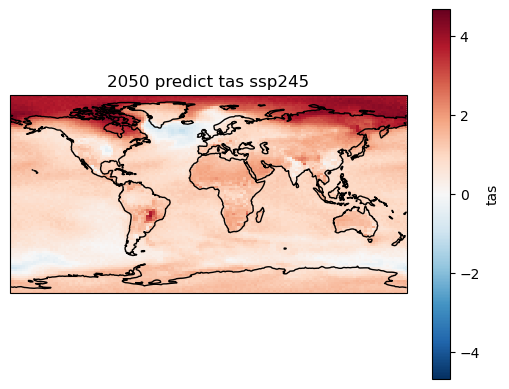

In [78]:
alpha = m_pred['tas'].sel(time=2050).plot(transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': ccrs.PlateCarree()})
plt.gca().set_title('2050 predict tas ssp245')
plt.gca().coastlines()

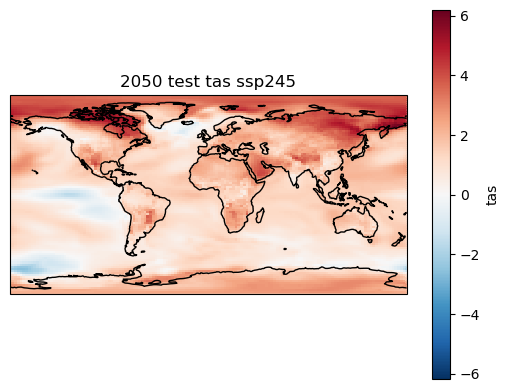

In [79]:
beta = Y_test['tas'].sel(time=2050, member=1).plot(transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': ccrs.PlateCarree()})
plt.gca().set_title('2050 test tas ssp245')
plt.gca().coastlines()

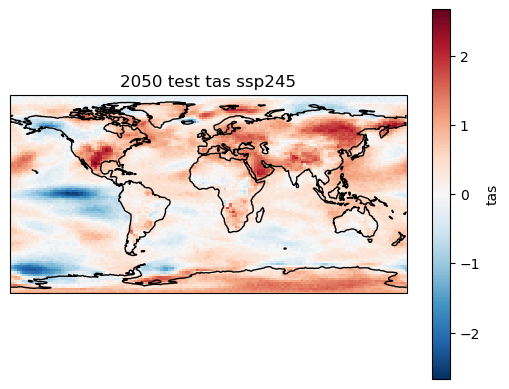

In [80]:
(Y_test['tas'].sel(member=1)-m_pred['tas']).sel(time=2050).plot(transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': ccrs.PlateCarree()})
plt.gca().set_title('2050 test tas ssp245')
plt.gca().coastlines()